In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import random as rd

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.util import minibatch, compounding
from nltk.stem.porter import *  

import re
import urllib.request
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

nlp = spacy.load("en_core_web_md")

from spacy import displacy
import df_helper as dfh
import nlp_support as ns


from sklearn.utils.random import sample_without_replacement
import importlib
import pickle
from sklearn.feature_selection import SelectKBest, chi2,  RFE, RFECV, SelectFpr

In [39]:
importlib.reload(dfh)

<module 'df_helper' from '/home/marco/UD/NLP_disaster/df_helper.py'>

In [3]:
from sklearn.base import TransformerMixin


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix

import sklearn.metrics as met
from sklearn.metrics import precision_recall_curve, roc_curve, auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, average_precision_score, auc, \
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, \
    brier_score_loss, roc_auc_score

from scipy.stats import randint as sp_randint , uniform
import eli5

In [ ]:
if 0:

    X_train,Y_train,X_test, Y_test,X_valid, Y_valid= load_data()
    n_false_sample= 0
    n_features=5000

    DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
    print(DOE)

    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )

    with open('%s_data.pkl' % DOE, 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(bow1k_bal, f)
    print('Saved')

In [4]:
import pickle

with open('false_0_nwords_5000_mindf_1_data.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_set = pickle.load(f)

In [5]:
N_est=50
k=100

cl_dict=dict()

for k in [10, 20, 50, 100, 200, 500, 1000,2000]:

    cl_dict['fs %d' % k]=Pipeline([
        ('fs', SelectKBest(chi2, k=k) ),
        ('rf',RandomForestClassifier(  criterion="entropy",class_weight="balanced", n_estimators=N_est))    
    ])



In [6]:
rf=dfh.dict_clf_estimate(cl_dict,data_set)

fs 10
fs 20
fs 50
fs 100
fs 200
fs 500
fs 1000
fs 2000


In [7]:
importlib.reload(dfh)

<module 'df_helper' from '/home/marco/UD/NLP_disaster/df_helper.py'>

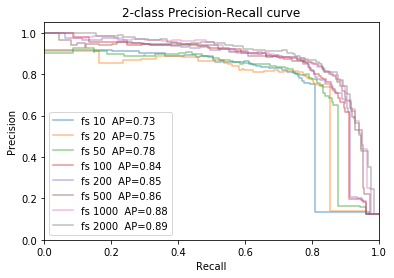

In [8]:
dfh.plot_pr_mat(rf)

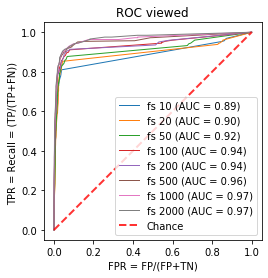

In [9]:
dfh.plot_roc_mat(rf)

In [20]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def confusion_matrix_threshold(y_test,y_prob,levels=200,normalize_all=False,normalize_class=True):
    
    thresholds=np.linspace(0,1,levels)
    tp=0*thresholds
    tn=0*thresholds
    fp=0*thresholds
    fn=0*thresholds

    n=0
    for threshold in thresholds:
        y_pred_threshold=y_prob > threshold 
        tp[n]=np.sum( y_test & y_pred_threshold)
        tn[n]=np.sum( ~y_test & ~y_pred_threshold)
        fp[n]=np.sum( ~y_test & y_pred_threshold)
        fn[n]=np.sum( y_test & ~y_pred_threshold)

        n+=1
        
    if normalize_all:
        n=y_test.shape[0]
        return(tn/n, fp/n, fn/n, tp/n,thresholds )
    elif normalize_class:
        npos=np.sum(y_test)
        nn=y_test.shape[0]-npos
        
        return(tn/nn, fp/nn, fn/npos, tp/npos,thresholds )
    else:
        return(tn, fp, fn, tp,thresholds )
    
def plot_prob_cal(df,bins=10):

    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for n in df.index:

        prob_pos=df.loc[n,'y_score']
        name=df.loc[n,'model']
        y_test=df.loc[n,'y_test']

        prob_pos =   (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=bins)
        brier_score = brier_score_loss(y_test, prob_pos, pos_label=1)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s  (%1.3f)" % (name,brier_score ))

        ax2.hist(prob_pos, range=(0, 1), bins=bins, label=name,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

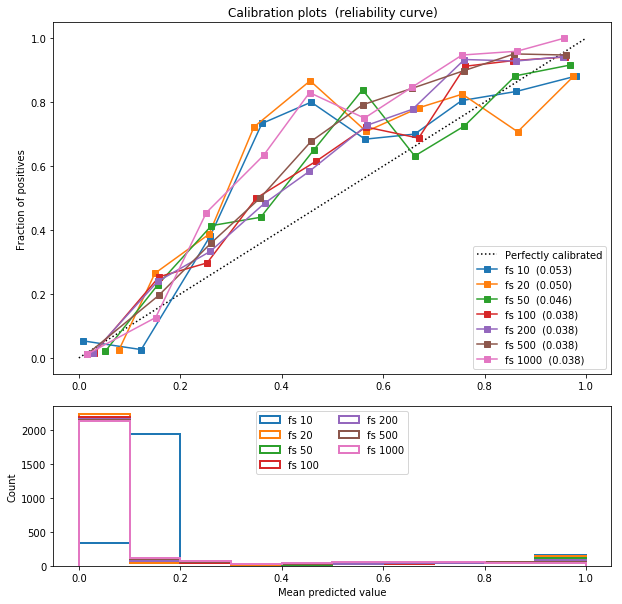

In [21]:
plot_prob_cal(rf)

In [35]:

def _xlim(ax,xlim):
    if not xlim:
        ax.set_xlim(xlim)
            
def plot_cm_mat(df,xlim=None):


    fig = plt.figure(1, figsize=(10, 10))
    ax1=plt.subplot(2,2,1)
    ax2=plt.subplot(2,2,2)
    ax3=plt.subplot(2,2,3)
    ax4=plt.subplot(2,2,4)
    
    
    for n in df.index:
  
        y_score=df.loc[n,'y_score']
        y_test=df.loc[n,'y_test']
        name=df.loc[n,'model']

        #tn, fp, fn, tp,t=dfh.confusion_matrix_threshold(y_test,y_score,levels=200,normalize_class=False);

        
#         ax1.plot(t,tn,'-',label=name);
        ax1.set_ylabel('TN')
        ax1.set_xlabel('threshold')
        _xlim(ax1,xlim)
        

#         ax2.plot(t,tp,'-',label=name);
        ax4.set_ylabel('TP')
        ax4.set_xlabel('threshold')
        _xlim(ax4,xlim)

#         ax3.plot(t,fn,'--',label=name);
        ax3.set_ylabel('FN')
        ax3.set_xlabel('threshold')
        _xlim(ax3,xlim)

#         ax4.plot(t,fp,'--',label=name);
        ax2.set_ylabel('FP')
        ax2.set_xlabel('threshold')
        _xlim(ax2,xlim)

    plt.legend()
        
    return(ax1,ax2,ax3,ax4)


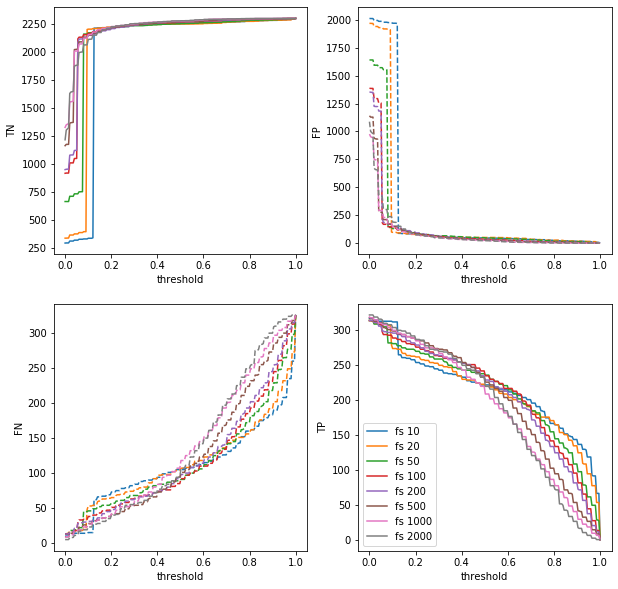

In [53]:
ax1,ax2,ax3,ax4=dfh.plot_cm_mat(rf,xlim=[0.2,.6])

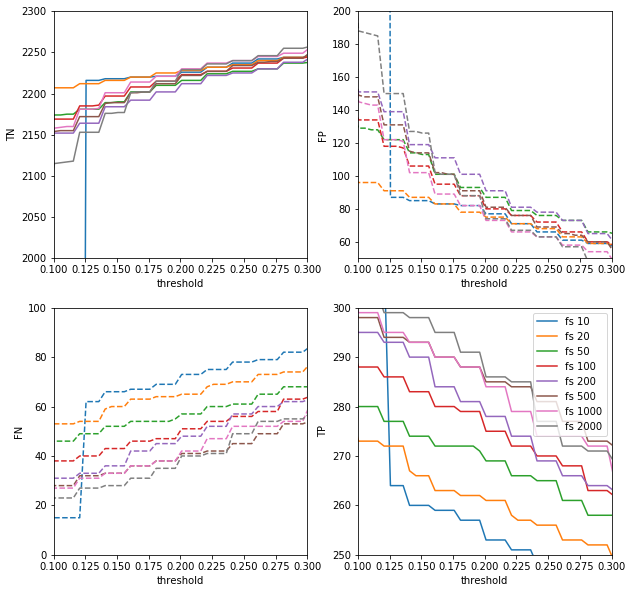

In [52]:
ax1,ax2,ax3,ax4=dfh.plot_cm_mat(rf,xlim=[0.2,.6])
T1=0.1
T2=0.3


ax1.axis([T1 , T2, 2000,2300]);
ax2.axis([T1 , T2, 50,200]);
ax3.axis([T1 , T2, 0,100]);
ax4.axis([T1 , T2, 250,300]);

In [48]:
importlib.reload(dfh)

<module 'df_helper' from '/home/marco/UD/NLP_disaster/df_helper.py'>